<a href="https://colab.research.google.com/github/Ao-Baid/steamrecommendation/blob/main/Steam_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
%pip install ipywidgets

   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 31.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Import necessary libraries for data visualisation, training and evaluation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import json
import csv

Loading the data

In [13]:
def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df

def data_generator(df, chunksize=10000):
    for i in range(0, df.shape[0], chunksize):
        yield df.iloc[i:i+chunksize]

root_dir = 'data'

df_games = reduce_memory(pd.read_csv(root_dir + '/games.csv'))
df_games_meta = reduce_memory(pd.read_json(root_dir + '/games_metadata.json', lines=True, orient="records"))
df_recommendations = reduce_memory(pd.read_csv(root_dir + '/recommendations.csv'))
df_users = reduce_memory(pd.read_csv(root_dir + '/users.csv'))

pd.DataFrame([
    ["Recommendations", len(df_recommendations.index)],
    ["Users", len(df_users.index)],
    ["Games", len(df_games.index)],
    ["Games Metadata", len(df_games_meta.index)]
], columns=["Dataframe", "Records"])

,Dataframe,Records
0,Recommendations,41154794
1,Users,14306064
2,Games,50872
3,Games Metadata,50872


A clearer view of the games tables and the attributes it contains:


*   app_id (native product ID on steam)
*   title
*   date_release
*   OS support
*   Product rating type
*   Ratio of positive feedbacks
*   Number of reviews
*   Pricing (original and discounted)
*   Steam Deck compatibility




In [14]:
df_games.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


Users table contains the attributes:


*   user_id (Primary key)
*   Number of products purchased by the user
*   Number of reviews published on steam



In [15]:
df_users.head()

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2


Recommendations table contains the attributes:

* Primary key: review auto-generated ID
* Foreign key on Games table: native product ID on Steam
* Foreign key on Users table: user augo
* How many users found a recommendation helpful/funny
* Product recommended (not recommended) by user
* How many hours played by the user.

In [16]:
df_recommendations.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.299999,51580,0
1,304390,4,0,2017-02-17,False,11.500000,2586,1
2,1085660,2,0,2019-11-17,True,336.500000,253880,2
3,703080,0,0,2022-09-23,True,27.400000,259432,3
4,526870,0,0,2021-01-10,True,7.900000,23869,4


# Data Preparation

**Check for missing values**

In [17]:
def percentage_na(df: pd.DataFrame) -> float:
  """Calculates the percentage of missing values in the dataframe we created"""
  return np.count_nonzero(df.isnull().values) / (df.shape[0] * df.shape[1]) * 100

pd.DataFrame([
    ["Recommendations", percentage_na(df_recommendations)],
    ["Users", percentage_na(df_users)],
    ["Games", percentage_na(df_games)],
], columns=["Dataframe", "% of Missing Values"])


,Dataframe,% of Missing Values
0,Recommendations,0.0
1,Users,0.0
2,Games,0.0


# Distribution of game ratings
Using the games table, we can create a distribution to showcase the most common game ratings.

From this chart, games are usually rated more postively than negatively and the proportion of overwhelmingly positive games to overwhelmingly negative games is considerable

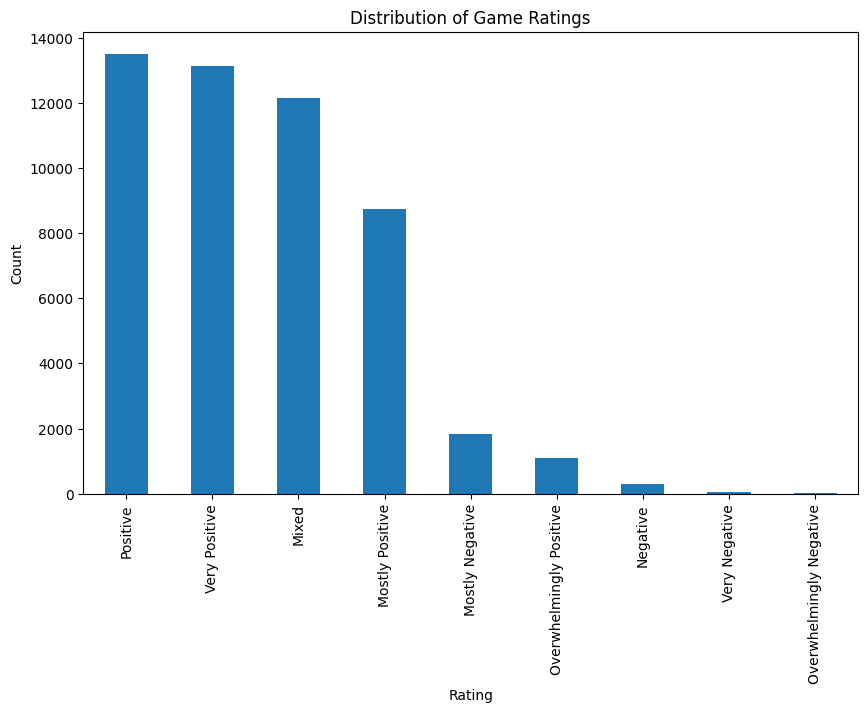

In [18]:
plt.figure(figsize=(10, 6))
df_games['rating'].value_counts().plot(kind='bar')
plt.title('Distribution of Game Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Most common gaming categories

<Figure size 1200x800 with 0 Axes>

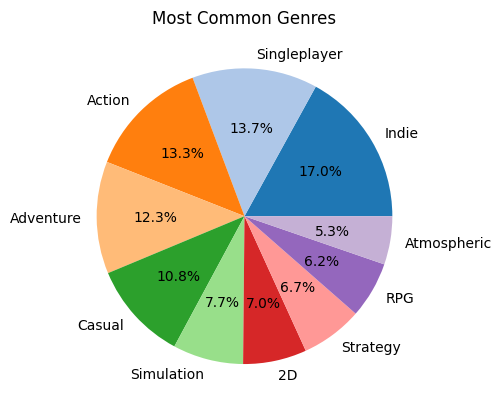

In [19]:
from collections import Counter

# Extract genres from the tags column
genres = df_games_meta['tags'].explode()

# Count the occurrences of each genre
genre_counts = Counter(genres)

# Convert the counts to a DataFrame
df_genre_counts = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

# Sort the DataFrame by count in descending order
df_genre_counts = df_genre_counts.sort_values(by='Count', ascending=False)

# Plot the most common genres as a pie chart
plt.figure(figsize=(12, 8))
colors = plt.cm.tab20(np.linspace(0, 1, 20))
df_genre_counts.head(10).set_index('Genre').plot(kind='pie', y='Count', legend=False, autopct='%1.1f%%', colors=colors)
plt.title('Most Common Genres')
plt.ylabel('')
plt.show()


# Collaborative filtering
Here will be a user-user collaboritive filtering model which uses K-Nearest Neighbours (KNN). This model recommends users who are similar to a given user

In [20]:
from scipy.sparse import coo_matrix

# map each user and item to a unique numeric value
user_ids = df_recommendations['user_id'].astype('category').cat.codes
item_ids = df_recommendations['app_id'].astype('category').cat.codes

# Get the unique user and game ids
unique_user_ids = df_recommendations['user_id'].astype('category').cat.categories
unique_item_ids = df_recommendations['app_id'].astype('category').cat.categories

# create a sparse matrix
user_game_matrix = coo_matrix((df_recommendations['hours'], (user_ids, item_ids)))

# Fit the model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_game_matrix)

# Get top 5 recommendations for first user
distances, indices = model_knn.kneighbors(user_game_matrix.getrow(0), n_neighbors=6)
recommended_users = [unique_user_ids[i] for i in indices.flatten()[1:]]
print(f'Recommended users for the first user are: {recommended_users}')

Recommended users for the first user are: [np.int32(11422900), np.int32(7483536), np.int32(9284221), np.int32(6590596), np.int32(11161013)]


# Content based filtering

Creating a content-based filtering model that uses TF-IDF vectorizer and cosine similarity. 

In [64]:
# Enhanced tag-based recommendations with game metadata

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import gc
import re

def create_enhanced_features(df_games_meta, df_games, sample_size=None):
    """Create a feature dataframe with both tags and important metadata"""
    # Initialize an empty list to store feature dictionaries
    feature_list = []
    
    # Optionally sample the metadata
    if sample_size and sample_size < len(df_games_meta):
        df_games_meta_sample = df_games_meta.sample(sample_size)
    else:
        df_games_meta_sample = df_games_meta
    
    # Process each game
    for _, game in df_games_meta_sample.iterrows():
        app_id = game.get('app_id')
        # Get basic game info
        game_info = df_games[df_games['app_id'] == app_id]
        if not game_info.empty:
            title = game_info['title'].values[0]
            
            # Extract tags and genres
            tags = game.get('tags', []) if 'tags' in game else []
            genres = game.get('genres', []) if 'genres' in game else []
            
            # Get additional metadata
            developer = game.get('developer', '') if 'developer' in game else ''
            publisher = game.get('publisher', '') if 'publisher' in game else ''
            release_year = None
            
            # Extract release year from date if available
            if 'date_release' in game_info.columns:
                date_str = game_info['date_release'].values[0]
                if isinstance(date_str, str) and date_str:
                    # Try to extract year from date string
                    year_match = re.search(r'(\d{4})', date_str)
                    if year_match:
                        release_year = int(year_match.group(1))
            
            # Get price and other numeric data
            price = game_info['price_final'].values[0] if 'price_final' in game_info.columns else None
            rating_value = None
            
            # Convert rating string to numeric value
            if 'rating' in game_info.columns:
                rating_str = game_info['rating'].values[0]
                if isinstance(rating_str, str):
                    if 'Overwhelmingly Positive' in rating_str:
                        rating_value = 95
                    elif 'Very Positive' in rating_str:
                        rating_value = 85
                    elif 'Positive' in rating_str:
                        rating_value = 75
                    elif 'Mostly Positive' in rating_str:
                        rating_value = 65
                    elif 'Mixed' in rating_str:
                        rating_value = 50
                    elif 'Mostly Negative' in rating_str:
                        rating_value = 35
                    elif 'Negative' in rating_str:
                        rating_value = 25
                    elif 'Very Negative' in rating_str:
                        rating_value = 15
                    elif 'Overwhelmingly Negative' in rating_str:
                        rating_value = 5
            
            # Store data with separate tag information and metadata
            feature_list.append({
                'app_id': app_id,
                'title': title,
                'tags': tags,
                'genres': genres,
                'all_tags': tags + genres,
                'developer': developer,
                'publisher': publisher,
                'release_year': release_year,
                'price': price,
                'rating_value': rating_value
            })
    
    # Convert to DataFrame
    return pd.DataFrame(feature_list)

# Create enhanced feature dataframe
enhanced_features = create_enhanced_features(df_games_meta, df_games, sample_size=10000)

# Filter out games with no tags and missing critical data
enhanced_features = enhanced_features[
    (enhanced_features['all_tags'].apply(lambda x: len(x) > 0)) &
    (~enhanced_features['title'].isna())
]

print(f"Processing {len(enhanced_features)} games with enhanced metadata")

# Add popularity metrics
enhanced_features = enhanced_features.merge(
    df_games[['app_id', 'positive_ratio', 'user_reviews']], 
    on='app_id', 
    how='left'
)

# Fill NA values
enhanced_features['positive_ratio'] = enhanced_features['positive_ratio'].fillna(0)
enhanced_features['user_reviews'] = enhanced_features['user_reviews'].fillna(0)
enhanced_features['rating_value'] = enhanced_features['rating_value'].fillna(50)  # Neutral rating as default
enhanced_features['price'] = enhanced_features['price'].fillna(-1)  # -1 as marker for unknown price

# Calculate popularity score
max_reviews = enhanced_features['user_reviews'].max()
enhanced_features['popularity_score'] = (
    0.7 * (enhanced_features['positive_ratio'] / 100) + 
    0.3 * (enhanced_features['user_reviews'] / max_reviews)
)

# Create a binary tag matrix (games × tags)
print("Creating tag matrix...")

# Get all unique tags
all_tags = set()
for tags in enhanced_features['all_tags']:
    all_tags.update(tags)

print(f"Found {len(all_tags)} unique tags/genres")

# Create a binary matrix for tags
tag_matrix = np.zeros((len(enhanced_features), len(all_tags)))
tag_list = list(all_tags)

# Fill the matrix with 1s where a game has a tag
for i, tags in enumerate(enhanced_features['all_tags']):
    for tag in tags:
        if tag in tag_list:
            j = tag_list.index(tag)
            tag_matrix[i, j] = 1

# Calculate tag-based similarity
print("Calculating tag-based similarity...")
tag_sim = cosine_similarity(tag_matrix)

print("Tag similarity matrix shape:", tag_sim.shape)

# Helper function to categorize games by price
def get_price_category(price):
    if price < 0:
        return "Unknown"
    elif price == 0:
        return "Free"
    elif price < 10:
        return "Budget (<$10)"
    elif price < 30:
        return "Mid-range ($10-30)"
    else:
        return "Premium ($30+)"

# Add price category
enhanced_features['price_category'] = enhanced_features['price'].apply(get_price_category)

# Helper function to get decade from release year
def get_decade(year):
    if year is None:
        return "Unknown"
    elif year < 1990:
        return "Pre-1990s"
    elif year < 2000:
        return "1990s"
    elif year < 2010:
        return "2000s"
    elif year < 2020:
        return "2010s"
    else:
        return "2020s"

# Add decade
enhanced_features['decade'] = enhanced_features['release_year'].apply(get_decade)

# Function to get enhanced recommendations based on common tags with metadata filtering
def get_enhanced_recommendations(title, n=10, price_range=None, decade=None, min_rating=None):
    """
    Get recommendations with enhanced metadata filtering
    
    Parameters:
    - title: Game title to find similar games for
    - n: Number of recommendations to return
    - price_range: Optional tuple (min_price, max_price) to filter games
    - decade: Optional decade to filter games (e.g., "2010s")
    - min_rating: Optional minimum rating value to filter games
    """
    try:
        # Get the index of the game
        if title not in enhanced_features['title'].values:
            print(f"Game title '{title}' not found. Here are some available titles:")
            return enhanced_features['title'].sample(5).values
        
        game_idx = enhanced_features[enhanced_features['title'] == title].index[0]
        source_game = enhanced_features.iloc[game_idx]
        
        # Get the game's tags
        game_tags = source_game['all_tags']
        
        # Get tag similarity scores
        tag_scores = tag_sim[game_idx]
        
        # Create a preliminary recommendations dataframe
        all_games = enhanced_features.copy()
        all_games['tag_similarity'] = tag_scores
        
        # Find common tags with the input game
        all_games['common_tags'] = all_games['all_tags'].apply(
            lambda x: [tag for tag in x if tag in game_tags]
        )
        all_games['common_tag_count'] = all_games['common_tags'].apply(len)
        
        # Filter out the source game
        recommendations = all_games[all_games.index != game_idx].copy()
        
        # Apply metadata filters if specified
        if price_range is not None and len(price_range) == 2:
            min_price, max_price = price_range
            if max_price > 0:  # Only filter if max_price is positive
                recommendations = recommendations[
                    (recommendations['price'] >= min_price) & 
                    (recommendations['price'] <= max_price)
                ]
        
        if decade is not None:
            recommendations = recommendations[recommendations['decade'] == decade]
        
        if min_rating is not None:
            recommendations = recommendations[recommendations['rating_value'] >= min_rating]
        
        # Sort by common tag count and then by tag similarity
        recommendations = recommendations.sort_values(
            ['common_tag_count', 'tag_similarity', 'popularity_score'], 
            ascending=[False, False, False]
        )
        
        # Format for display with metadata
        result = recommendations[[
            'title', 'common_tags', 'common_tag_count', 'tag_similarity',
            'developer', 'publisher', 'release_year', 'decade',
            'price', 'price_category', 'rating_value', 'positive_ratio'
        ]].head(n)
        
        # Print source game info
        print(f"\nOriginal game: {source_game['title']}")
        print(f"Developer: {source_game['developer']}")
        print(f"Release Year: {source_game['release_year']}")
        print(f"Tags: {game_tags}")
        
        return result
    
    except Exception as e:
        print(f"Error getting enhanced recommendations: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

# Function to recommend based on a set of tags with enhanced metadata
def recommend_by_tags_enhanced(tags, n=10, price_range=None, decade=None, min_rating=None):
    """Recommend games based on tags with enhanced metadata filtering"""
    try:
        # Convert tags to lowercase for case-insensitive matching
        search_tags = [tag.lower() for tag in tags]
        
        # Score each game based on tag matches
        all_games = enhanced_features.copy()
        
        # Find matching tags with the input tags
        all_games['matching_tags'] = all_games['all_tags'].apply(
            lambda x: [tag for tag in x if tag.lower() in search_tags]
        )
        all_games['matching_tag_count'] = all_games['matching_tags'].apply(len)
        
        # Calculate tag match score
        all_games['tag_match_score'] = all_games['matching_tag_count'] / len(search_tags)
        
        # Apply metadata filters if specified
        recommendations = all_games.copy()
        
        if price_range is not None and len(price_range) == 2:
            min_price, max_price = price_range
            if max_price > 0:  # Only filter if max_price is positive
                recommendations = recommendations[
                    (recommendations['price'] >= min_price) & 
                    (recommendations['price'] <= max_price)
                ]
        
        if decade is not None:
            recommendations = recommendations[recommendations['decade'] == decade]
        
        if min_rating is not None:
            recommendations = recommendations[recommendations['rating_value'] >= min_rating]
        
        # Filter to only include games with at least one matching tag
        recommendations = recommendations[recommendations['matching_tag_count'] > 0]
        
        # Sort by matching tag count, then by popularity
        recommendations = recommendations.sort_values(
            ['matching_tag_count', 'popularity_score'],
            ascending=[False, False]
        )
        
        # Format for display with metadata
        result = recommendations[[
            'title', 'matching_tags', 'matching_tag_count', 'tag_match_score',
            'developer', 'publisher', 'release_year', 'decade',
            'price', 'price_category', 'rating_value', 'positive_ratio'
        ]].head(n)
        
        return result
    
    except Exception as e:
        print(f"Error getting enhanced tag recommendations: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

# Function for enhanced mood-based recommendations
def get_mood_recommendations_enhanced(mood, n=10, price_range=None, decade=None, min_rating=None):
    """Get enhanced recommendations based on a mood with metadata filtering"""
    # Map moods to relevant tags - refined list based on Steam tags
    mood_tag_mapping = {
        'happy': ['Colorful', 'Cute', 'Family Friendly', 'Casual', 'Comedy', 'Funny'],
        'excited': ['Action', 'Fast-Paced', 'Competitive', 'Multiplayer', 'Shooter', 'Racing'],
        'relaxed': ['Casual', 'Relaxing', 'Simulation', 'Puzzle', 'Atmospheric', 'Sandbox'],
        'thoughtful': ['Strategy', 'Puzzle', 'Story Rich', 'Turn-Based', 'Tactical', 'Building'],
        'social': ['Multiplayer', 'Co-op', 'Online Co-Op', 'Team-Based', 'Party Game', 'MMO'],
        'adventurous': ['Open World', 'Exploration', 'Adventure', 'RPG', 'Fantasy', 'Action-Adventure'],
        'scary': ['Horror', 'Survival Horror', 'Psychological Horror', 'Dark', 'Atmospheric', 'Zombies'],
        'creative': ['Building', 'Sandbox', 'Crafting', 'Simulation', 'Management', 'Design']
    }
    
    # Get tags for the given mood
    tags = mood_tag_mapping.get(mood.lower(), ['Action', 'Adventure'])
    print(f"Finding '{mood}' games with tags: {tags}")
    
    # Get recommendations based on tags with enhanced filtering
    return recommend_by_tags_enhanced(tags, n, price_range, decade, min_rating)

# Function to get similar games with price filtering
def get_similar_games_by_price(title, price_range, n=10):
    """Find games similar to the given title within a specific price range"""
    return get_enhanced_recommendations(title, n, price_range=price_range)

# Function to get games from same developer/publisher
def get_games_from_same_developer(title, n=10):
    """Find other games from the same developer as the given title"""
    try:
        # Get the source game
        if title not in enhanced_features['title'].values:
            print(f"Game title '{title}' not found.")
            return pd.DataFrame()
        
        source_game = enhanced_features[enhanced_features['title'] == title].iloc[0]
        developer = source_game['developer']
        
        if not developer or developer == '':
            print(f"No developer information for {title}")
            return pd.DataFrame()
        
        # Find games from the same developer
        developer_games = enhanced_features[
            (enhanced_features['developer'] == developer) &
            (enhanced_features['title'] != title)
        ]
        
        # Sort by popularity
        developer_games = developer_games.sort_values('popularity_score', ascending=False)
        
        print(f"\nOther games by {developer} (developer of {title}):")
        
        return developer_games[[
            'title', 'release_year', 'decade', 'price',
            'price_category', 'rating_value', 'positive_ratio'
        ]].head(n)
        
    except Exception as e:
        print(f"Error finding games from same developer: {e}")
        return pd.DataFrame()

# Test enhanced recommendations
if len(enhanced_features) > 0:
    # Test tag-based recommendations for a popular game
    popular_games = enhanced_features.sort_values('popularity_score', ascending=False)
    
    # Try to find a well-known game in our dataset
    popular_game_titles = ['Counter-Strike', 'Grand Theft Auto V', 'The Witcher 3: Wild Hunt', 
                           'Stardew Valley', 'Terraria', 'Portal 2', 'Civilization VI']
    
    sample_game = None
    for title in popular_game_titles:
        # Use exact match instead of contains to avoid matching soundtracks and DLCs
        matches = enhanced_features[enhanced_features['title'] == title]
        if not matches.empty:
            sample_game = matches.iloc[0]['title']
            break
    
    # If no exact match found, try a more flexible search but exclude soundtracks and DLCs
    if sample_game is None:
        for title in popular_game_titles:
            matches = enhanced_features[
                (enhanced_features['title'].str.contains(title, case=False)) & 
                (~enhanced_features['title'].str.contains('Soundtrack', case=False)) &
                (~enhanced_features['title'].str.contains('DLC', case=False))
            ]
            if not matches.empty:
                sample_game = matches.iloc[0]['title']
                break
    
    if sample_game is None:
        # If none of the popular games are found, use the top popular game
        sample_game = popular_games.iloc[0]['title']
    
    print(f"\n1. Finding enhanced recommendations for: {sample_game}")
    recommendations = get_enhanced_recommendations(sample_game)
    print("\nRecommended games based on common tags with metadata:")
    display(recommendations)
    
    # Test recommendations with price filtering
    print(f"\n2. Finding budget alternatives to {sample_game} (under $10):")
    budget_recommendations = get_similar_games_by_price(sample_game, (0, 10))
    display(budget_recommendations)
    
    # Test developer recommendations
    print(f"\n3. Finding other games from the same developer:")
    developer_recommendations = get_games_from_same_developer(sample_game)
    display(developer_recommendations)
    
    # Test mood-based recommendations with era filtering
    test_mood = 'relaxed'
    test_decade = '2010s'
    print(f"\n4. Finding {test_decade} {test_mood} games with good ratings:")
    mood_decade_recommendations = get_mood_recommendations_enhanced(
        test_mood, 
        decade=test_decade, 
        min_rating=75
    )
    print(f"\nHighly-rated {test_decade} games for a '{test_mood}' mood:")
    display(mood_decade_recommendations)
    
    # Test explicit tag-based recommendations with metadata filtering
    test_tags = ['Open World', 'RPG', 'Fantasy']
    print(f"\n5. Finding modern premium games with tags: {test_tags}")
    tag_recommendations = recommend_by_tags_enhanced(
        test_tags,
        price_range=(30, 100),  # Premium games
        decade='2020s'          # Modern games
    )
    print("\nModern premium games matching these tags:")
    display(tag_recommendations)

Processing 9733 games with enhanced metadata
Creating tag matrix...
Found 438 unique tags/genres
Calculating tag-based similarity...
Tag similarity matrix shape: (9733, 9733)

1. Finding enhanced recommendations for: Counter-Strike: Source

Original game: Counter-Strike: Source
Developer: 
Release Year: 2004
Tags: ['Shooter', 'Action', 'FPS', 'Multiplayer', 'Team-Based', 'First-Person', 'Tactical', 'Competitive', 'PvP', 'eSports', 'Military', 'War', 'Strategy', 'Moddable', 'Singleplayer', 'Difficult', 'Atmospheric', 'Survival', 'Simulation', 'Sandbox']

Recommended games based on common tags with metadata:


,title,common_tags,common_tag_count,tag_similarity,developer,publisher,release_year,decade,price,price_category,rating_value,positive_ratio
6557,Counter-Strike: Condition Zero,"[Action, FPS, Shooter, Multiplayer, First-Pers...",14,0.700000,,,2004,2000s,9.99,Budget (<$10),85,90
8426,ARMA: Cold War Assault,"[Simulation, Action, Military, Strategy, FPS, ...",14,0.700000,,,2011,2010s,4.99,Budget (<$10),85,89
9490,Armored Warfare - Free Globalization Pack,"[Strategy, Action, Simulation, FPS, War, Tacti...",12,0.600000,,,2018,2010s,0.00,Free,75,87
2058,Anarchy: Wolf's law,"[Action, Survival, PvP, Shooter, FPS, Tactical...",12,0.600000,,,2021,2020s,14.99,Mid-range ($10-30),85,84
4508,Post Scriptum,"[Simulation, FPS, Military, Multiplayer, Actio...",12,0.600000,,,2018,2010s,29.99,Mid-range ($10-30),85,80
496,Operation: Harsh Doorstop,"[Action, Military, Simulation, FPS, Strategy, ...",12,0.600000,,,2023,2020s,0.00,Free,50,65
1957,Umbrella Corps,"[Action, Multiplayer, Shooter, Singleplayer, S...",12,0.600000,,,2016,2010s,19.99,Mid-range ($10-30),35,35
6894,Brothers in Arms: Road to Hill 30™,"[FPS, Action, Shooter, War, First-Person, Tact...",11,0.614919,,,2008,2000s,9.99,Budget (<$10),85,87
9257,Tom Clancy's Rainbow Six® Vegas 2,"[Tactical, Action, FPS, Singleplayer, Shooter,...",11,0.550000,,,2008,2000s,9.99,Budget (<$10),85,85
8090,Quantum League,"[Action, Shooter, PvP, Multiplayer, Strategy, ...",11,0.550000,,,2021,2020s,9.99,Budget (<$10),75,78



2. Finding budget alternatives to Counter-Strike: Source (under $10):

Original game: Counter-Strike: Source
Developer: 
Release Year: 2004
Tags: ['Shooter', 'Action', 'FPS', 'Multiplayer', 'Team-Based', 'First-Person', 'Tactical', 'Competitive', 'PvP', 'eSports', 'Military', 'War', 'Strategy', 'Moddable', 'Singleplayer', 'Difficult', 'Atmospheric', 'Survival', 'Simulation', 'Sandbox']


,title,common_tags,common_tag_count,tag_similarity,developer,publisher,release_year,decade,price,price_category,rating_value,positive_ratio
6557,Counter-Strike: Condition Zero,"[Action, FPS, Shooter, Multiplayer, First-Pers...",14,0.700000,,,2004,2000s,9.99,Budget (<$10),85,90
8426,ARMA: Cold War Assault,"[Simulation, Action, Military, Strategy, FPS, ...",14,0.700000,,,2011,2010s,4.99,Budget (<$10),85,89
9490,Armored Warfare - Free Globalization Pack,"[Strategy, Action, Simulation, FPS, War, Tacti...",12,0.600000,,,2018,2010s,0.00,Free,75,87
496,Operation: Harsh Doorstop,"[Action, Military, Simulation, FPS, Strategy, ...",12,0.600000,,,2023,2020s,0.00,Free,50,65
6894,Brothers in Arms: Road to Hill 30™,"[FPS, Action, Shooter, War, First-Person, Tact...",11,0.614919,,,2008,2000s,9.99,Budget (<$10),85,87
9257,Tom Clancy's Rainbow Six® Vegas 2,"[Tactical, Action, FPS, Singleplayer, Shooter,...",11,0.550000,,,2008,2000s,9.99,Budget (<$10),85,85
8090,Quantum League,"[Action, Shooter, PvP, Multiplayer, Strategy, ...",11,0.550000,,,2021,2020s,9.99,Budget (<$10),75,78
2090,Tannenberg - Supporter Edition Upgrade,"[Strategy, Action, First-Person, Shooter, Mili...",11,0.550000,,,2017,2010s,4.99,Budget (<$10),85,94
1327,Mount & Blade: Warband - Napoleonic Wars,"[Action, Multiplayer, War, First-Person, Strat...",11,0.550000,,,2012,2010s,9.99,Budget (<$10),85,88
6322,The Undisputables : Online Multiplayer Shooter,"[Multiplayer, Shooter, Action, PvP, Competitiv...",11,0.550000,,,2021,2020s,6.99,Budget (<$10),75,75



3. Finding other games from the same developer:
No developer information for Counter-Strike: Source


""



4. Finding 2010s relaxed games with good ratings:
Finding 'relaxed' games with tags: ['Casual', 'Relaxing', 'Simulation', 'Puzzle', 'Atmospheric', 'Sandbox']

Highly-rated 2010s games for a 'relaxed' mood:


,title,matching_tags,matching_tag_count,tag_match_score,developer,publisher,release_year,decade,price,price_category,rating_value,positive_ratio
790,Tree Bonsai,"[Casual, Simulation, Relaxing, Sandbox, Atmosp...",6,1.000000,,,2019,2010s,1.990000,Budget (<$10),75,78
4092,KNIGHTS,"[Puzzle, Relaxing, Casual, Simulation, Atmosph...",5,0.833333,,,2016,2010s,0.490000,Budget (<$10),85,94
1558,Mars Power Industries Deluxe,"[Puzzle, Relaxing, Casual, Atmospheric, Simula...",5,0.833333,,,2019,2010s,5.990000,Budget (<$10),85,94
8907,Train Simulator: BR Class 45 'Peak' Loco Add-On,"[Simulation, Sandbox, Casual, Atmospheric, Rel...",5,0.833333,,,2014,2010s,19.990000,Mid-range ($10-30),75,92
5467,Train Valley 2,"[Sandbox, Casual, Simulation, Puzzle, Relaxing]",5,0.833333,,,2019,2010s,5.240000,Budget (<$10),85,91
2130,The Sapling,"[Sandbox, Simulation, Relaxing, Casual, Atmosp...",5,0.833333,,,2019,2010s,9.990000,Budget (<$10),85,89
8006,Pixel Art Monster - Color by Number,"[Relaxing, Puzzle, Casual, Simulation, Atmosph...",5,0.833333,,,2019,2010s,3.990000,Budget (<$10),75,83
6986,Verdant Skies,"[Casual, Simulation, Sandbox, Relaxing, Atmosp...",5,0.833333,,,2018,2010s,19.990000,Mid-range ($10-30),85,81
2619,Test your knowledge: Cities,"[Casual, Relaxing, Puzzle, Atmospheric, Simula...",5,0.833333,,,2018,2010s,3.990000,Budget (<$10),75,81
9648,Train Simulator: WCML Trent Valley Route Add-On,"[Simulation, Atmospheric, Sandbox, Relaxing, C...",5,0.833333,,,2015,2010s,39.990002,Premium ($30+),85,80



5. Finding modern premium games with tags: ['Open World', 'RPG', 'Fantasy']

Modern premium games matching these tags:


,title,matching_tags,matching_tag_count,tag_match_score,developer,publisher,release_year,decade,price,price_category,rating_value,positive_ratio
8567,Ys IX: Monstrum Nox,"[RPG, Fantasy, Open World]",3,1.000000,,,2021,2020s,59.990002,Premium ($30+),85,94
1392,The Lord of the Rings: Gollum™,"[Fantasy, RPG, Open World]",3,1.000000,,,2023,2020s,49.990002,Premium ($30+),35,20
3073,Etrian Odyssey III HD,"[RPG, Fantasy]",2,0.666667,,,2023,2020s,39.990002,Premium ($30+),85,96
9477,Labyrinth of Galleria: The Moon Society,"[RPG, Fantasy]",2,0.666667,,,2023,2020s,49.990002,Premium ($30+),75,95
4063,The Legend of Heroes: Kuro no Kiseki,"[RPG, Fantasy]",2,0.666667,,,2023,2020s,59.990002,Premium ($30+),75,95
6400,The Legend of Heroes: Trails of Cold Steel IV,"[RPG, Fantasy]",2,0.666667,,,2021,2020s,59.990002,Premium ($30+),85,94
1842,Atelier Ayesha: The Alchemist of Dusk DX,"[RPG, Fantasy]",2,0.666667,,,2020,2020s,39.990002,Premium ($30+),85,94
7956,EVERSPACE™ 2,"[Open World, RPG]",2,0.666667,,,2023,2020s,39.990002,Premium ($30+),85,88
4824,Wasteland 3,"[RPG, Open World]",2,0.666667,,,2020,2020s,39.990002,Premium ($30+),85,84
5104,Eiyu*Senki Gold – A New Conquest,"[RPG, Fantasy]",2,0.666667,,,2021,2020s,34.990002,Premium ($30+),85,84
